In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, softmax

%matplotlib widget

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [5]:
df = pd.read_csv("archive/song_data.csv")

df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [6]:
X, y = df.drop('song_name',axis=1).to_numpy(), df['song_popularity'].to_numpy()

In [7]:
model_regression = Sequential(
    [
        ### START CODE HERE ###

        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

        ### END CODE HERE ###
    ], name="my_regression_model"
)
model_regression.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     )

In [8]:
# Assuming 'y_reg' is your regression target variable
history_regression = model_regression.fit(
    X, y,
    epochs=100
)

Epoch 1/100
589/589 [==============================] - 1s 1ms/step - loss: 2204961.0000
Epoch 2/100
589/589 [==============================] - 1s 2ms/step - loss: 672.0870
Epoch 3/100
589/589 [==============================] - 1s 1ms/step - loss: 668.2633
Epoch 4/100
589/589 [==============================] - 1s 1ms/step - loss: 668.0210
Epoch 5/100
589/589 [==============================] - 1s 1ms/step - loss: 667.7488
Epoch 6/100
589/589 [==============================] - 1s 1ms/step - loss: 667.5911
Epoch 7/100
589/589 [==============================] - 1s 1ms/step - loss: 665.2985
Epoch 8/100
589/589 [==============================] - 1s 1ms/step - loss: 665.6142
Epoch 9/100
589/589 [==============================] - 1s 1ms/step - loss: 665.8315
Epoch 10/100
589/589 [==============================] - 1s 1ms/step - loss: 662.2779
Epoch 11/100
589/589 [==============================] - 1s 1ms/step - loss: 664.8588
Epoch 12/100
589/589 [==============================] - 1s 1ms/step - 

In [19]:
Ed_IHE_Remix = X[22]
print(Ed_IHE_Remix.shape)

# Assuming 'model_regression' is the name of your regression model
prediction = model_regression.predict(Ed_IHE_Remix.reshape(1, 14))

print(f"Predicted value for regression: {prediction}")

(14,)
1/1 [==============================] - 0s 25ms/step
Predicted value for regression: [[16.619768]]


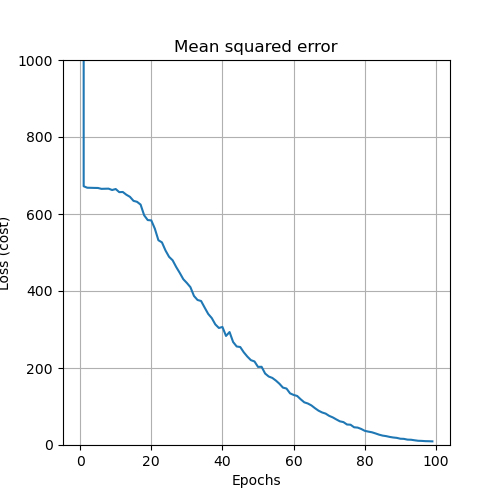

In [22]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (5,5))
    ax.plot(history.history['loss'], label='loss')
    ax.set_ylim([0, 1000])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (cost)')
    
    plt.title("Mean squared error")
    ax.grid(True)
    plt.show()
    
plot_loss_tf(history_regression)